In [1]:
import keras

Using TensorFlow backend.


In [119]:
model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

<h2>Task 1</h2>

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

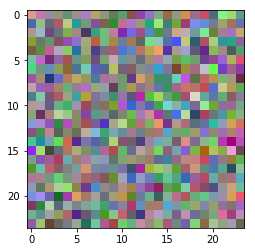

In [3]:
img =  model.get_weights()[0].reshape(24,24,3)

cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(img.astype('uint8'))

<h2>Task2</h2>

In [3]:
from keras import backend as K
from keras import Model

In [116]:
car = cv2.imread('data/cnn/cnn_car.png', cv2.COLOR_BGR2RGB)

In [147]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('block2_pool').output)
intermediate_output = intermediate_layer_model.predict(np.array([car]))

In [148]:
output_image = intermediate_output[0]

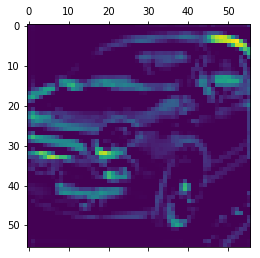

In [149]:
plt.matshow(output_image[:, :, 4], cmap='viridis')

<h2>Task 3</h2>

In [4]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

from os import listdir
from os.path import isfile, join
from random import shuffle


from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

In [11]:
dataset_path = 'data/cnn/cats_and_dogs'
label_categories = {'cat': 0, 'dog': 1}

In [12]:
flatten_layer = Model(inputs=model.input,
                                 outputs=model.get_layer('flatten').output)

In [13]:
features = []
labels = []
files_in_folder = listdir(dataset_path)
shuffle(files_in_folder)

for f in files_in_folder:
    if isfile(join(dataset_path, f)):
        img = cv2.imread(join(dataset_path, f), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224)) 
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)
        features.extend(flatten_layer.predict(x))
        labels.append(label_categories[f.split('.')[0]])
        if len(labels) > 2000:
            break

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20)

<h4>SVM</h4>

In [15]:
from sklearn.svm import SVC

In [16]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(train_features, train_labels) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [17]:
predicted_labels = svclassifier.predict(test_features) 

In [18]:
accuracy_score(test_labels, predicted_labels)

0.9775561097256857

<h4>Random Forest</h4>

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
clf = RandomForestClassifier(n_estimators=2000, max_depth=2,
                             random_state=0, n_jobs=-1)
clf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [21]:
clf_predicted_labels = clf.predict(test_features)

In [22]:
accuracy_score(test_labels, clf_predicted_labels)

0.9600997506234414

<h4>XGBoost</h4>

In [23]:
from xgboost import XGBClassifier

In [24]:
xgb = XGBClassifier(n_estimators=100, tree_metod='gpu_hist', verbose=1)

In [25]:
%%time
xgb.fit(np.array(train_features), train_labels)

Wall time: 1min 30s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_metod='gpu_hist', verbose=1)

In [26]:
xgb_predicted_labels = xgb.predict(test_features)

In [27]:
accuracy_score(test_labels, xgb_predicted_labels)

0.970074812967581

<h2>Task 4</h2>

In [5]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input

from keras.callbacks import EarlyStopping

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [30]:
(mnist_train_features, mnist_train_labels), (mnist_test_features, mnist_test_labels) = mnist.load_data()

In [31]:
mnist_train_features = mnist_train_features.reshape(mnist_train_features.shape[0], 28, 28, 1)
mnist_test_features = mnist_test_features.reshape(mnist_test_features.shape[0], 28, 28, 1)

In [32]:
mnist_train_features = mnist_train_features.astype("float32") / 255
mnist_test_features = mnist_test_features.astype("float32")/ 255
mnist_train_labels = keras.utils.to_categorical(mnist_train_labels)
mnist_test_labels = keras.utils.to_categorical(mnist_test_labels)

In [33]:
def own_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [34]:
cnn = own_cnn((28, 28, 1), 10)

In [35]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [36]:
cnn.fit(mnist_train_features, mnist_train_labels, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, batch_size=32)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 27s 499us/step - loss: 0.1021 - acc: 0.9698 - val_loss: 0.0621 - val_acc: 0.9857
Epoch 2/10
54000/54000 [==============================] - 22s 416us/step - loss: 0.0447 - acc: 0.9867 - val_loss: 0.0554 - val_acc: 0.9853
Epoch 3/10
54000/54000 [==============================] - 23s 421us/step - loss: 0.0317 - acc: 0.9905 - val_loss: 0.0508 - val_acc: 0.9868
Epoch 4/10
54000/54000 [==============================] - 23s 424us/step - loss: 0.0252 - acc: 0.9918 - val_loss: 0.0372 - val_acc: 0.9925
Epoch 5/10
54000/54000 [==============================] - 23s 423us/step - loss: 0.0199 - acc: 0.9943 - val_loss: 0.0365 - val_acc: 0.9902
Epoch 6/10
54000/54000 [==============================] - 22s 416us/step - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0399 - val_acc: 0.9902
Epoch 7/10
54000/54000 [==============================] - 23s 422us/step - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0

In [37]:
cnn.evaluate(mnist_test_features, mnist_test_labels)

10000/10000 [==============================] - 1s 124us/step


[0.029815044975569072, 0.9932]

In [38]:
test_image_cnn = cv2.imread('data/cnn/animal_number_2.png', cv2.IMREAD_GRAYSCALE)

In [39]:
test_image_cnn = cv2.resize(test_image_cnn, (28, 28)).astype("float32").reshape(28, 28, 1)/255

In [40]:
np.argmax(cnn.predict([[test_image_cnn]]))+1

2

<h2>Task 5</h2>

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [42]:
datagen = ImageDataGenerator(rotation_range=20)

In [43]:
datagen.fit(mnist_train_features)

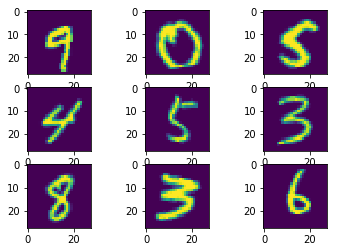

In [44]:
for X_batch, y_batch in datagen.flow(mnist_train_features, mnist_train_labels, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28))
    plt.show()
    break

In [45]:
cnn.fit_generator(datagen.flow(mnist_train_features, mnist_train_labels, batch_size=32), epochs=10, steps_per_epoch=len(mnist_train_features) / 32)

Epoch 1/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0395 - acc: 0.9899
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0228 - acc: 0.9934
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0242 - acc: 0.9934
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0200 - acc: 0.9939
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0176 - acc: 0.9948
Epoch 6/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0180 - acc: 0.9947
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0147 - acc: 0.9955
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0151 - acc: 0.9955
Epoch 9/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0154 - acc: 0.9956
Epoch 10/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0128 - acc: 0.9962


In [46]:
cnn.evaluate(mnist_test_features, mnist_test_labels)

10000/10000 [==============================] - 1s 138us/step


[0.028036046048282606, 0.9929]

<h2>Task 6</h2>

In [7]:
from keras.datasets import cifar10
from PIL import Image
from skimage.transform import resize

In [79]:
(cifar10_train_features, cifar10_train_labels), (cifar10_test_features, cifar10_test_labels) = cifar10.load_data()

In [80]:
cifar10_train_features = cifar10_train_features.astype("float32") / 255
cifar10_test_features = cifar10_test_features.astype("float32") / 255

In [81]:
cifar10_train_labels = keras.utils.to_categorical(cifar10_train_labels)

In [82]:
cifar10_test_labels = keras.utils.to_categorical(cifar10_test_labels)

In [83]:
resnet50 = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(32, 32, 3)))

C:\Users\Goodman\Anaconda3\envs\tutelaris\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [96]:
for layer in resnet50.layers:
    layer.trainable = False

In [109]:
def resnet50_cifar10_extended(resnet50):
    model = Sequential()
    model.add(resnet50)
    model.add(Conv2D(512, kernel_size=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size= (1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(),#lr=0.0, decay=0.0),
                  metrics=['accuracy'])
    return model

In [110]:
resnet_extended = resnet50_cifar10_extended(resnet50)

In [99]:
datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [100]:
datagen.fit(cifar10_train_features)

In [113]:
resnet_extended.fit_generator(datagen.flow(cifar10_train_features, cifar10_train_labels, batch_size=32), steps_per_epoch=len(cifar10_train_features)/32, epochs=10)

Epoch 1/10
1563/1562 [==============================] - 54s 35ms/step - loss: 0.2385 - acc: 0.9097
Epoch 2/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2372 - acc: 0.9099
Epoch 3/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2351 - acc: 0.9106
Epoch 4/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2345 - acc: 0.9111
Epoch 5/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2331 - acc: 0.9110
Epoch 6/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2320 - acc: 0.9113
Epoch 7/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2308 - acc: 0.9117
Epoch 8/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2299 - acc: 0.9123
Epoch 9/10
1563/1562 [==============================] - 56s 36ms/step - loss: 0.2298 - acc: 0.9123
Epoch 10/10
1563/1562 [==============================] - 55s 35ms/step - loss: 0.2281 - acc: 0.9127


In [114]:
resnet_extended.evaluate(cifar10_test_features, cifar10_test_labels)

10000/10000 [==============================] - 11s 1ms/step


[0.3509224348068237, 0.8928599822998047]

<h2>Task 7</h2>

In [8]:
from keras.preprocessing.image import load_img, img_to_array
from scipy.optimize import fmin_l_bfgs_b
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.applications import VGG16

from keras import backend

In [9]:
cImPath = 'data/cnn/photo.jpg'
sImPath = 'data/cnn/vangog.jpg'
height = 512
width = 512

In [10]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

In [11]:
content_image=Image.open(cImPath)
content_image=content_image.resize((512,512))

In [12]:
style_image= Image.open(sImPath)
style_image=style_image.resize((512,512))

In [13]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)

In [14]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

In [15]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

In [16]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]

In [17]:
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

In [18]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [19]:
vgg16 = VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

In [20]:
layers=dict([(layer.name, layer.output) for layer in vgg16.layers])

In [21]:
loss=backend.variable(0.)

In [22]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [23]:
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss = loss + content_weight*content_loss(content_image_features,combination_features)

In [24]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [25]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [26]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [27]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss = loss + (style_weight/len(feature_layers))*sl

In [28]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [29]:
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [30]:
grads = backend.gradients(loss, combination_image)

In [31]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [32]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [33]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [34]:
evaluator=Evaluator()

In [37]:
x = np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 100

In [38]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
51234636000.0
Iteration 0 completed in 13s
Start of iteration 1
27609960000.0
Iteration 1 completed in 13s
Start of iteration 2
23266775000.0
Iteration 2 completed in 14s
Start of iteration 3
21394400000.0
Iteration 3 completed in 14s
Start of iteration 4
20566745000.0
Iteration 4 completed in 14s
Start of iteration 5
20060473000.0
Iteration 5 completed in 14s
Start of iteration 6
19751928000.0
Iteration 6 completed in 14s
Start of iteration 7
19543603000.0
Iteration 7 completed in 14s
Start of iteration 8
19415558000.0
Iteration 8 completed in 14s
Start of iteration 9
19334148000.0
Iteration 9 completed in 14s
Start of iteration 10
19278703000.0
Iteration 10 completed in 14s
Start of iteration 11
19240786000.0
Iteration 11 completed in 14s
Start of iteration 12
19216050000.0
Iteration 12 completed in 14s
Start of iteration 13
19200430000.0
Iteration 13 completed in 14s
Start of iteration 14
19189713000.0
Iteration 14 completed in 14s
Start of iteration 15
19182850

In [39]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

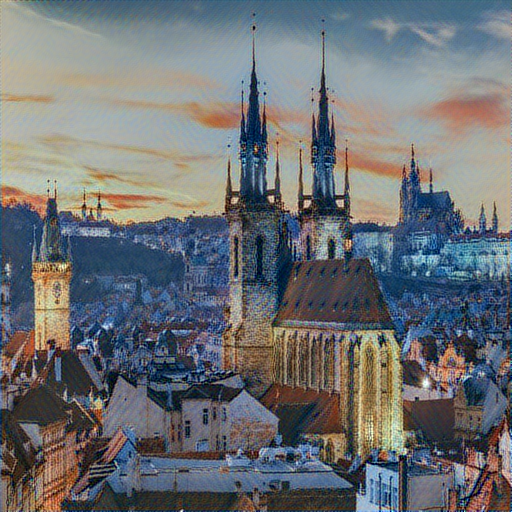

In [40]:
Image.fromarray(x)